In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
from utils import load_mnist
from trainer import Trainer

In [4]:
from argparse import Namespace

config = {
    'train_ratio': .8,
    'batch_size': 256,
    'n_epochs': 50,
    'verbose': 1,
    'btl_size': 2
}

config = Namespace(**config)
print(config)

Namespace(batch_size=256, btl_size=2, n_epochs=50, train_ratio=0.8, verbose=1)


In [5]:
def show_image(x):
    if x.dim() == 1:
        x = x.view(int(x.size(0)** .5), -1)
        
    plt.imshow(x, cmap='gray')
    plt.show()

In [6]:
train_x, train_y = load_mnist(flatten=True)
test_x, test_y = load_mnist(is_train=False, flatten=True)

train_cnt = int(train_x.size(0) * config.train_ratio)
valid_cnt = train_x.size(0) - train_cnt

indices = torch.randperm(train_x.size(0))
train_x, valid_x = torch.index_select(train_x, dim=0, index=indices).split([train_cnt, valid_cnt], dim=0)
train_y, valid_y = torch.index_select(train_y, dim=0, index=indices).split([train_cnt, valid_cnt], dim=0)

print('Train', train_x.shape, train_y.shape)
print('Valid', valid_x.shape, valid_y.shape)
print('Test', test_x.shape, test_y.shape)

Train torch.Size([48000, 784]) torch.Size([48000])
Valid torch.Size([12000, 784]) torch.Size([12000])
Test torch.Size([10000, 784]) torch.Size([10000])


In [7]:
from model import Autoencoder

In [8]:
model = Autoencoder(btl_size=config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

trainer = Trainer(model, optimizer, crit)

In [9]:
trainer.train((train_x, train_x), (valid_x, valid_x), config)

Epoch(1/50): train_loss=7.2330e-02  valid_loss=4.8901e-02  lowest_loss=4.8901e-02
Epoch(2/50): train_loss=4.7306e-02  valid_loss=4.4502e-02  lowest_loss=4.4502e-02
Epoch(3/50): train_loss=4.4754e-02  valid_loss=4.3585e-02  lowest_loss=4.3585e-02
Epoch(4/50): train_loss=4.3660e-02  valid_loss=4.1903e-02  lowest_loss=4.1903e-02
Epoch(5/50): train_loss=4.2683e-02  valid_loss=4.1460e-02  lowest_loss=4.1460e-02
Epoch(6/50): train_loss=4.2097e-02  valid_loss=4.0762e-02  lowest_loss=4.0762e-02
Epoch(7/50): train_loss=4.2043e-02  valid_loss=4.0856e-02  lowest_loss=4.0762e-02
Epoch(8/50): train_loss=4.1821e-02  valid_loss=3.9852e-02  lowest_loss=3.9852e-02
Epoch(9/50): train_loss=4.1179e-02  valid_loss=3.9998e-02  lowest_loss=3.9852e-02
Epoch(10/50): train_loss=4.1633e-02  valid_loss=4.1304e-02  lowest_loss=3.9852e-02
Epoch(11/50): train_loss=4.0797e-02  valid_loss=4.0289e-02  lowest_loss=3.9852e-02
Epoch(12/50): train_loss=4.0849e-02  valid_loss=3.8973e-02  lowest_loss=3.8973e-02
Epoch(13/50):

**Test**

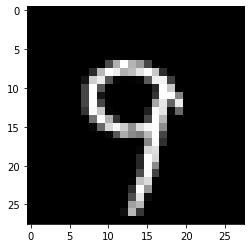

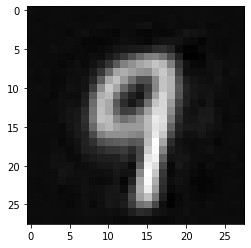

In [10]:
with torch.no_grad():
    import random
    
    index = int(random.random() * test_x.size(0))
    
    recon = model(test_x[index].view(1,-1)).squeeze()
    
    show_image(test_x[index])
    show_image(recon)

**Latent Space**

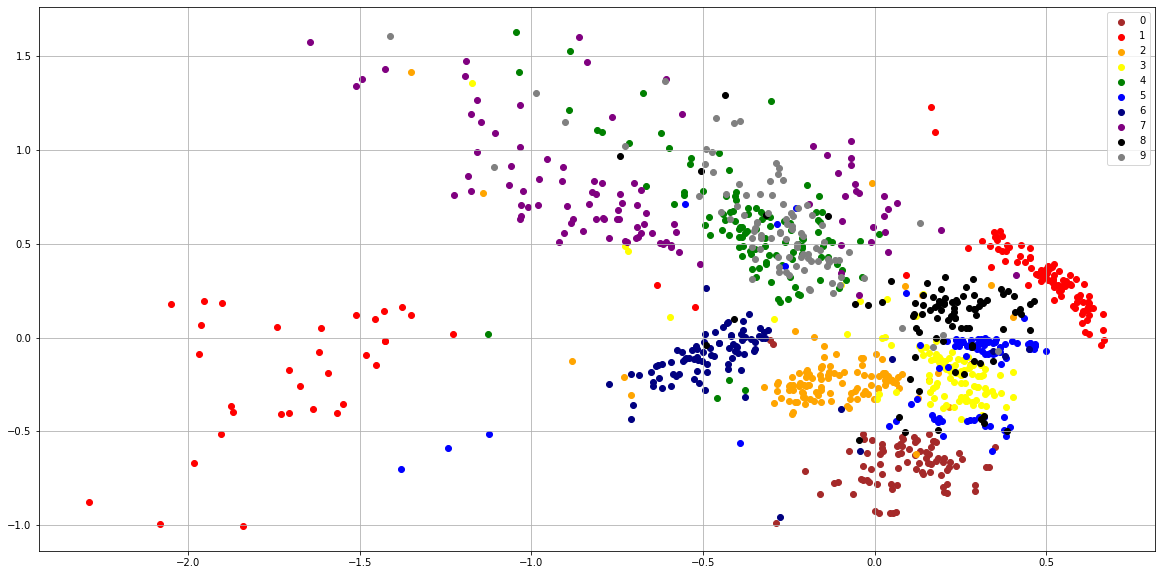

In [13]:
# encoder를 통과시킨 결과 z 값

if config.btl_size == 2:
    color_map = [
        'brown', 'red', 'orange', 'yellow', 'green', 'blue', 'navy', 'purple', 'black', 'gray',
    ]
    plt.figure(figsize=(20,10))
    with torch.no_grad():
        latents = model.encoder(test_x[:1000])
        
        for i in range(10):
            target_latents = latents[test_y[:1000] == i]
            target_y = test_y[:1000][test_y[:1000] == i]
            plt.scatter(target_latents[:,0], target_latents[:,1], marker='o', color=color_map[i], label=i)
        plt.legend()
        plt.grid(axis='both')
        plt.show()

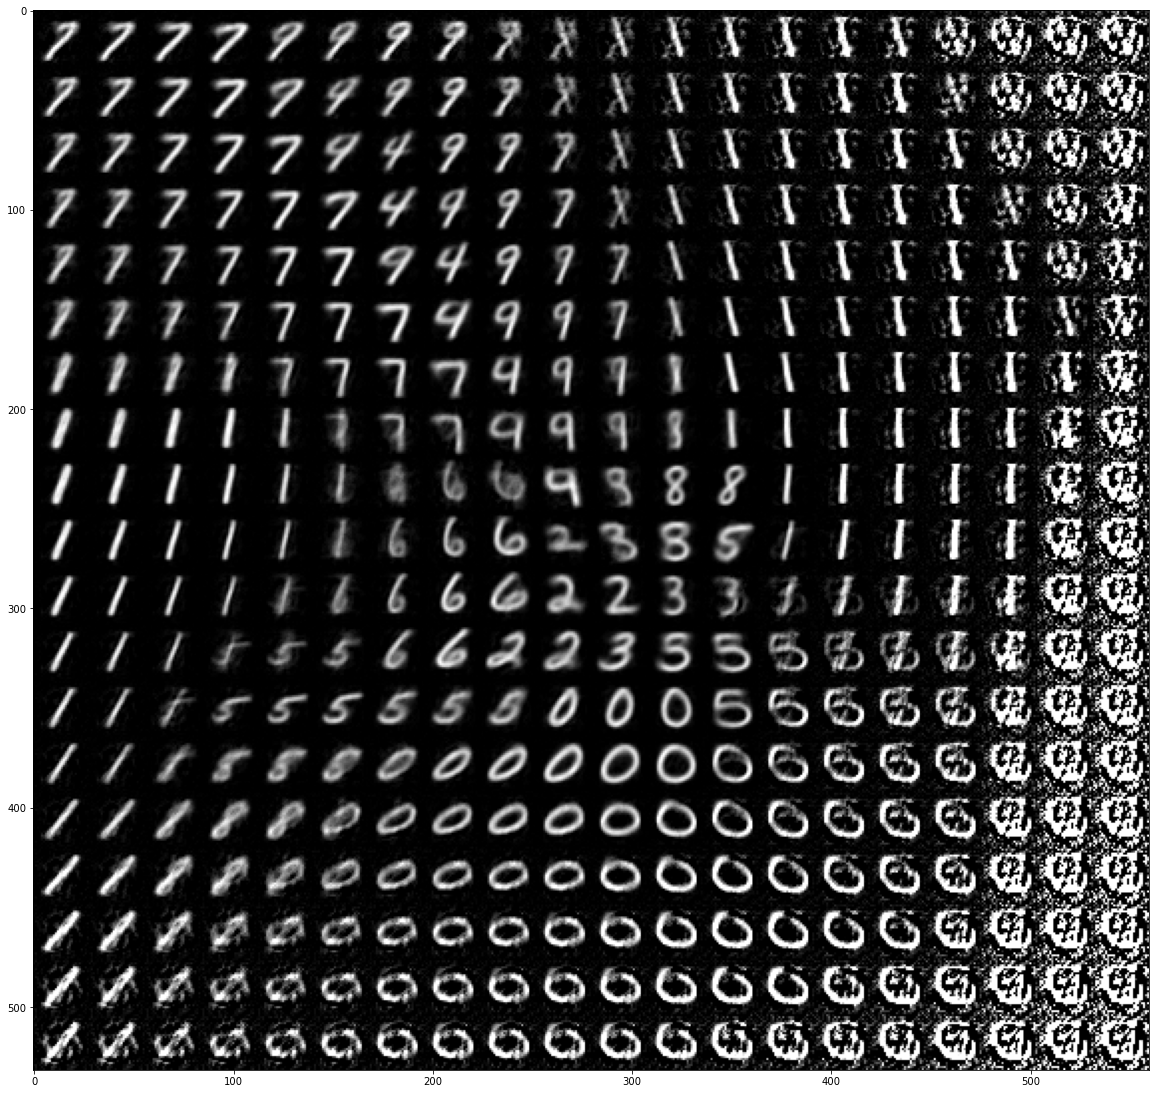

In [17]:
# decoder를 통과시켜 나온 z 결과 값

if config.btl_size == 2:
    min_range, max_range = -2., 2.
    n = 20
    step = (max_range - min_range) / float(n)
    
    with torch.no_grad():
        lines = []
        
        for vl in np.arange(min_range, max_range, step):
            z = torch.stack([
                torch.FloatTensor([vl] * n),
                torch.FloatTensor([v2 for v2 in np.arange(min_range, max_range, step)])
            ], dim=-1)
            
            line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
            line = torch.cat([line[i] for i in range(n-1, 0, -1)], dim=0)
            lines += [line]
        lines = torch.cat(lines, dim=-1)
        plt.figure(figsize=(20,20))
        show_image(lines)